# Yandex load toy-test

## Test plan description

1. HTTP GET https://yandex.ru
    * Check response status == 200 OK.
    * Wait for 250-750 ms delay.
* HTTP GET https://yandex.ru/images/
    * Check response status == 200 OK.
    * Wait for 250-750 ms delay.
* HTTP GET https://yandex.ru/images/search?text=load+testing
    * Check response status == 200 OK.
    * extract random `//a[@class="serp-item__link"]/@href` value from response HTML.
    * extract `img_url` query parameter value from `href`.
    * Wait for 250-750 ms delay.


### Test paramters:
  - 10 Users.
  - 200 Loop count.
  - 60 [s] ramp-up.

## Run load test

In [ ]:
! cat ./run-yandex-load-test.sh
! ./run-yandex-load-test.sh

## Read test result

In [1]:
import pandas as pd
import numpy as np

labels = [
    'HTTP Request [main page "/"]',
    'HTTP Request [images search page "/images/"]',
    'HTTP Request [image search result page "/images?search?text=load testing"]',
    'HTTP Request [random image page]'
]

report_file_name = "yandex-load-test-report.jtl"

df = pd.read_csv(report_file_name)
df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit = "ms")
df["offset [s]"] = df["timeStamp"] - df["timeStamp"].min()
df = df[df["label"].isin(labels)]
df = df.rename(columns = {
    "Latency": "Latency [ms]",
    "elapsed": "elapsed [ms]"
})

df.head()

,timeStamp,elapsed [ms],label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency [ms],IdleTime,Connect,offset [s]
0,2020-05-02 12:07:53.071,755,"HTTP Request [main page ""/""]",200,Ok,Thread Group [yandex] 1-1,text,True,NaN,71553,1229,1,1,https://yandex.ru/,712,0,283,00:00:00
1,2020-05-02 12:07:54.386,968,"HTTP Request [images search page ""/images/""]",200,OK,Thread Group [yandex] 1-1,text,True,NaN,61302,1236,1,1,https://yandex.ru/images/,935,0,0,00:00:01.315000
2,2020-05-02 12:07:55.902,657,"HTTP Request [image search result page ""/image...",200,OK,Thread Group [yandex] 1-1,text,True,NaN,90125,1260,1,1,https://yandex.ru/images/search?text=load+testing,619,0,89,00:00:02.831000
3,2020-05-02 12:07:57.402,1026,HTTP Request [random image page],200,OK,Thread Group [yandex] 1-1,bin,True,NaN,85378,1284,1,1,https://www.cyberthai.com/images/enterprisenet...,701,0,381,00:00:04.331000
4,2020-05-02 12:07:58.992,424,"HTTP Request [main page ""/""]",200,Ok,Thread Group [yandex] 1-1,text,True,NaN,70453,1229,2,2,https://yandex.ru/,390,0,77,00:00:05.921000


In [2]:
print(f'Test duration: {df["offset [s]"].max()}')
print(f'Concurrent users: {len(df["grpThreads"].unique())}')

print("Request counts by type:")
df["label"].value_counts()


Test duration: 0 days 22:21:29.063000
Concurrent users: 10
Request counts by type:


HTTP Request [main page "/"]                                                  3200
HTTP Request [random image page]                                              3200
HTTP Request [image search result page "/images?search?text=load testing"]    3200
HTTP Request [images search page "/images/"]                                  3200
Name: label, dtype: int64

## Results

In [3]:
def mean(ls):
    return np.round(np.mean(ls), -1)
def q75(ls):
    return np.round(np.quantile(ls, 0.75), -1)
def q90(ls):
    return np.round(np.quantile(ls, 0.90), -1)
def q95(ls):
    return np.round(np.quantile(ls, 0.95), -1)
def q975(ls):
    return np.round(np.quantile(ls, 0.975), -1)
def q99(ls):
    return np.round(np.quantile(ls, 0.99), -1)
def std(ls):
    return np.round(np.std(ls), -1)

df_latency_by_label = df[["label", "Latency [ms]"]].groupby("label")

df_latency_by_label_stat = df_latency_by_label.agg([mean, q75, q90, q95, q975, q99, std])
df_latency_by_label_stat

Latency [ms]              \
                                                           mean   q75   q90   
label                                                                         
HTTP Request [image search result page "/images...          750   730   900   
HTTP Request [images search page "/images/"]               1020  1040  1140   
HTTP Request [main page "/"]                                520   490   650   
HTTP Request [random image page]                            530   640  1190   

                                                                           
                                                     q95  q975   q99  std  
label                                                                      
HTTP Request [image search result page "/images...  1060  1340  3870  660  
HTTP Request [images search page "/images/"]        1240  1450  4600  670  
HTTP Request [main page "/"]                         800  1040  4480  720  
HTTP Request [random image page]                    1520  1860  5660  960

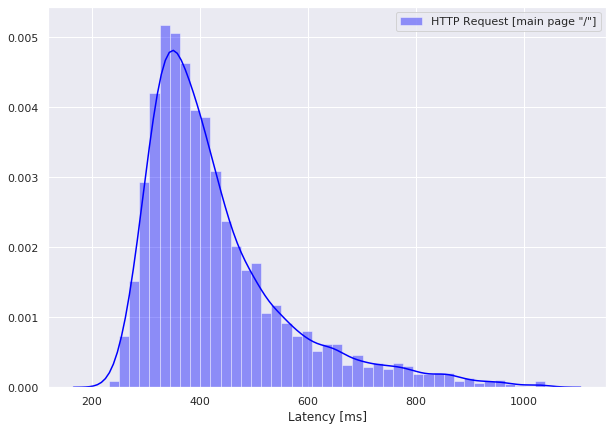

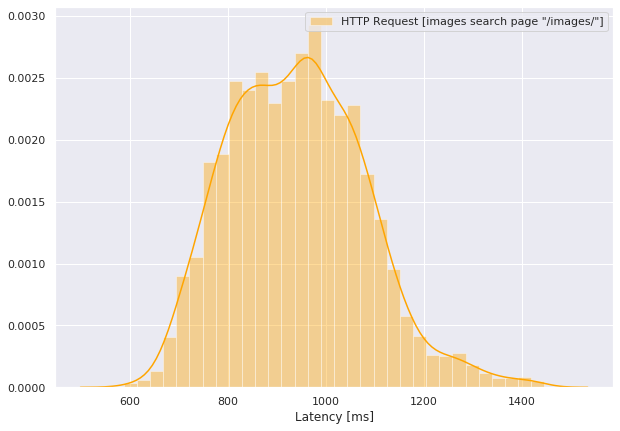

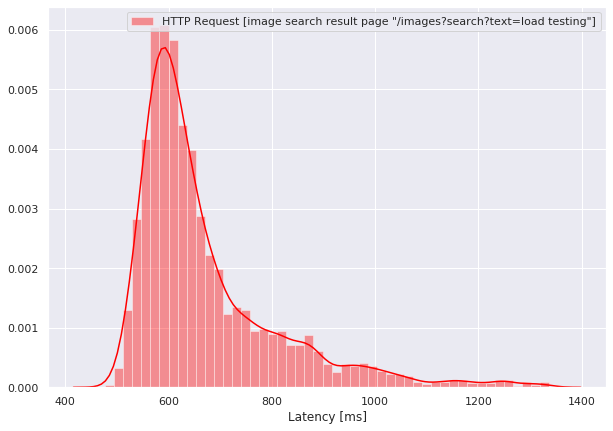

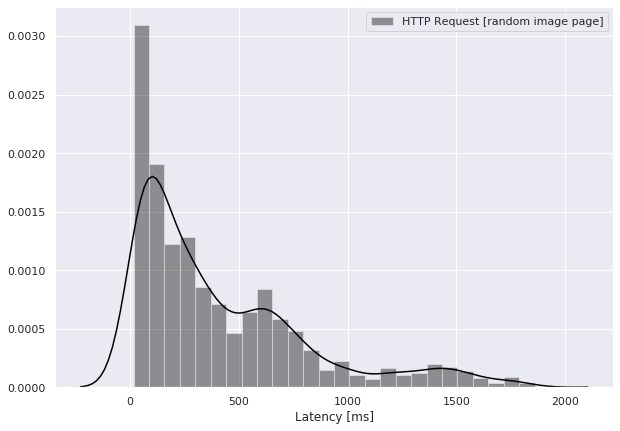

In [4]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set(rc = {"figure.figsize": (10, 7)})

q975_by_label = dict(df_latency_by_label_stat[("Latency [ms]",  "q975")])

def filter_q975(ls, label):
    return [l for l in ls if l < q975_by_label[label] ]
    
colors = ["blue", "orange", "red", "black"]
for color, label in zip(colors, labels):
    ax = sns.distplot(
        filter_q975(df[df["label"] == label]["Latency [ms]"].values, label),
        label = label,
        color = color
    )
    ax.set(xlabel = "Latency [ms]")
    plt.legend()
    plt.show()


In [44]:
from statsmodels.stats.proportion import proportion_confint

total_requests_per_label = df["label"].value_counts()
total_failures_per_label = df["label"].value_counts() - df[df["success"]]["label"].value_counts()

p_value = 0.99
bounds = proportion_confint(
    total_failures_per_label,
    total_requests_per_label,
    method = "wilson",
    alpha = 1 - p_value
)

print(f"Probobility of failure [p_value = {p_value}]")
pd.DataFrame(zip(labels, *bounds), columns = ["label", "p_min", "p_max"])

Probobility of failure [p_value = 0.99]


,label,p_min,p_max
0,"HTTP Request [main page ""/""]",0.0,0.002069
1,"HTTP Request [images search page ""/images/""]",0.0,0.002069
2,"HTTP Request [image search result page ""/image...",0.0,0.002069
3,HTTP Request [random image page],0.0,0.002069


* Throughput was not analyzed - it was limited by test scenario and there is no way to account for millions other users performing requests at the time of test.  
* `HTTP Request [main page "/"]` and `HTTP Request [image search result page "/images?search?text=load testing"]` have similar latency distributions - both resourses returend same content during the test.
* `HTTP Request [images search page "/images/"]` latency distribution is a bit wider than the rest - probably it's because `/images/` every time returns different set of default images.